신경망 모델 구현하기 

1) 인공신경망 (ANN)

    - 인간의 신경계의 작동 방식에서 영감을 받아 생성된 모델
    - 입력층(자극=데이터를 입력받는 감각기관)을 거쳐 은닉층을지나 마지막 출력층으로 전달
    - 각 층에 존재하는 한 단위의 인공 뉴런을 노드라고 한다. 
    - 인공신경망의 각 노드는 입력된 데이터에 특정한 수학 연산 수행
    
      ( 각 층의 매개변수인 가중치에 행렬곱시키고 편향을 더 함 )
    - 행렬곱의 결과는 활성화함수를 거쳐 인공 뉴런의 결과값을 산출
      
      ( 활성화 함수는 입력을 처리하여 출력 신호로 변환하는 함수로 입력 신호의 합이 활성화를 일으키는지를 정하는 역할 )
      
    - 인공 뉴런의 결과값은 은닉층으로 전달되어 다시 한번 가중치 곱과 활성화 함수를 거친다.
    - 이러한 과정을 반복하여 마지막 출력층에서 결과값을 만들어 내는 것이 인공 신경망의 기본적인 작동원리 
    - 마지막 결과값과 정답을 비교해 오차를 계산하고 이를 기반으로 신경망 전체를 학습시키기위해 
    
      출력층 가중치부터 입력층 가중치까지 모두 경사하강법을 활용해 변경해주며 차례대로 조정하고 최적화하는 
      
      알고리즘이 역전파(Backpropagtion)알고리즘이다. 

In [15]:
#간단한 분류 모델 구현 
#0과 1로 구분된 이진분류
#라이브러리 임포트
import torch
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [16]:
#데이터셋 생성
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

#사이킷런의 달 데이터를 가지고 2차원 벡터 형태로 생성

In [17]:
#각 데이터에 정답 레이블 
#4개의 레이블을 2개로 합치기 
#0 = 0, 1 번 레이블 / 1 = 2, 3번 레이블
def label_map(y_, from_, to_):
    y = np.copy(y_)
    for f in from_:
        y[y_==f]  = to_
    return y
    
y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

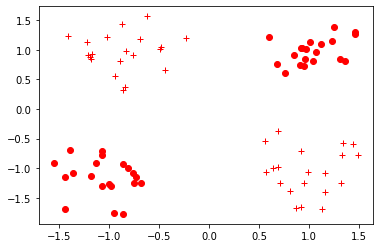

In [19]:
#데이터 레이블링 확인위한 시각화
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()



대부분의 신경망 학습은 대량의 학습데이터를 이용하지만, 매번 전부 이용해서 오차를 구하고 학습하는 것은 비효율적이라

전체 데이터셋을 배치라는 작은 세트로 나눠 보통 하나의 배치로 오차를 구한다.

In [21]:
#방금 생성한 넘파이 벡터 형식 데이터를 텐서로 변경
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [29]:
#모델 구현 
class NeuralNet(torch.nn.Module):
    #신경망 구조와 동작 정의하는 생성자 모델 정의
    #__init__은 파이썬에서 객체가 갖는 속성값을 초기화 역할, 객체 생성시 자동 호출
    #super()를 통해 이 클래스는 파이토치의 nn.Module 클래스 속성들을 가지고 초기화
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        #인공 신경망을 거치며 수행하는 연산 정의
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
        #torch.nn.linear()는 행렬곱과 편향을 포합하는 연산을 지원하는 객체 반환
        #relu와 sigmoid는 각 단계에서 수행할 활성화 함수
        
    #위 함수에서 정의한 동작을 차례대로 수행하는 forward 함수 구현
    def forward(self, input_tensor):
        linear1=self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output
    
#linear_1은 입력 데이터에 input_size ,hidden_size 크기의 가중치를 행렬곱하고 편향을 더하여
#[1, hidden_size]꼴의 텐서 반환
#그 후 Relu활서오하 함수 적용 ( 0보다 작으면 0을 0보다 크면 입력값 그대로 출력)
#relu를 지나 linear_2의 행렬곱을 거쳐 [1,1]꼴로 반환 후 sigmoid에 입력
#sigmoid는 0과 1사이의 값을 반환

In [30]:
#신경망 객체 생성 후 학습에 필요한 변수와 알고리즘 정의
model = NeuralNet(2,5)
learning_rate = 0.03
criterion = torch.nn.BCELoss() #이진 교차 엔트로피 
epochs = 2000 #데이터 입력횟수 
optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate) #확률적 경사하강법
                                                                   #optimizer는 step()함수를 부를때마다 가중치를 학습률만큼 갱신

In [32]:
#모델 성능 평가
#결과값과 레이블값의 차원을 맞추기 위해 squeeze()를 호출 후 오차 구하기 

model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Befor Training, test loss : ', test_loss_before.item()) #item함수는 텐서 속의 숫자를 스칼라로 반환

Befor Training, test loss :  0.6813948750495911


In [33]:
#신경망 학습시켜 성능 개선

for epoch in range(epochs):
    #학습모드로 변경
    model.train()
    #epoch마다 새로운 경사값을 계산하므로 zero_grad()함수를 호출해 경사를 0으로 설정
    optimizer.zero_grad()
    train_output = model(x_train)
    #결과값의 차원을 레이블의 차원과 같게 만들고 오차 계산
    train_loss = criterion(train_output.squeeze(), y_train)
    #100 epoch마다 오차 출력
    if epoch %100 == 0:
        print('train loss :', epoch, train_loss.item())
    #오차 함수를 가중치로 미분하여 오차의 최소를 구하고, 그 방향으로 학습률만큼 이동 ( 역전파를 행하는 코드)
    train_loss.backward()
    optimizer.step()
    

train loss : 0 0.6815881133079529
train loss : 100 0.5910043120384216
train loss : 200 0.5139264464378357
train loss : 300 0.440202534198761
train loss : 400 0.3738214671611786
train loss : 500 0.3168368935585022
train loss : 600 0.2688789367675781
train loss : 700 0.22922837734222412
train loss : 800 0.1965920627117157
train loss : 900 0.17017564177513123
train loss : 1000 0.14826372265815735
train loss : 1100 0.13050547242164612
train loss : 1200 0.11611463874578476
train loss : 1300 0.1042964905500412
train loss : 1400 0.0945563092827797
train loss : 1500 0.08623816817998886
train loss : 1600 0.07913041859865189
train loss : 1700 0.07302345335483551
train loss : 1800 0.06765006482601166
train loss : 1900 0.06295351684093475


In [35]:
#신경망 성능 테스트

#모델 평가모드로 변경
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After training, test loss :', test_loss.item())

After training, test loss : 0.08863048255443573


학습 후, 오차가 매우 줄어들었다. 

In [36]:
#학습 모델을 state_dict()함수형태로 바꿔, .pt 파일로 저장 
#state_dict()는 모델 내 가중치들이 딕셔너리 형태로 {연산 이름: 가중치 텐서와 편향 텐서}와 같이 표현된 데이터 

torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model :', model.state_dict())

state_dict format of the model : OrderedDict([('linear_1.weight', tensor([[-1.0522, -1.0152],
        [ 0.2423, -1.7688],
        [-1.6388, -1.5645],
        [-1.7908,  1.3474],
        [-0.0416, -0.1106]])), ('linear_1.bias', tensor([-0.3247,  1.1100, -0.4882,  0.1338, -0.3998])), ('linear_2.weight', tensor([[-1.4880,  1.9524, -2.2086,  2.1575, -0.4390]])), ('linear_2.bias', tensor([-1.9295]))])


In [38]:
#위의 가중치와 편향을 새로운 모델에 바로 적용가능
new_model = NeuralNet(2,5)
new_model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [42]:
#확인
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률 :{}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률 :0.994117021560669
